[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Wouknnlb28L9LfzryQzSa2reZNkGi01z)

# Download data and install libs

In [0]:
!wget -nc -O train.csv https://www.dropbox.com/s/bx1n4arnm7eoj5u/train.csv?dl=1
!wget -nc -O test.csv https://www.dropbox.com/s/ypb2ve9aiq73uch/test.csv?dl=1
!wget -nc -q https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/san-francisco.geojson

In [0]:
!pip install shapely geopandas

In [0]:
import numpy as np
import pandas  as pd
import datetime
import time
from itertools import product
from tqdm.autonotebook import tqdm
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


# Preprocess data

In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [0]:
df_train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [0]:
# analyse the first 5 rows of test data
df_test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [0]:
df_train['split'] = 'train'
df_test['split'] = 'test'

## Filter samples with invalid lat/long from train set

In [0]:
df_train = df_train[abs(df_train['Y']) < 90]

## Replace invalid lat/long in test set with district median

In [0]:
district_medians = df_test.groupby('PdDistrict').agg('median').to_dict()
district_medians

{'Id': {'BAYVIEW': 449390.0,
  'CENTRAL': 427595.5,
  'INGLESIDE': 451944.5,
  'MISSION': 449974.0,
  'NORTHERN': 462192.0,
  'PARK': 428394.0,
  'RICHMOND': 433635.5,
  'SOUTHERN': 416986.5,
  'TARAVAL': 458804.0,
  'TENDERLOIN': 446971.0},
 'X': {'BAYVIEW': -122.39264034869,
  'CENTRAL': -122.40919390461599,
  'INGLESIDE': -122.428732393148,
  'MISSION': -122.419360352761,
  'NORTHERN': -122.425564924002,
  'PARK': -122.4453467866,
  'RICHMOND': -122.46620466789301,
  'SOUTHERN': -122.40535937175301,
  'TARAVAL': -122.47564746078599,
  'TENDERLOIN': -122.412930522059},
 'Y': {'BAYVIEW': 37.7340319720999,
  'CENTRAL': 37.794826475914896,
  'INGLESIDE': 37.72569335757029,
  'MISSION': 37.76101609120561,
  'NORTHERN': 37.7854818747419,
  'PARK': 37.770311544715,
  'RICHMOND': 37.78057886087829,
  'SOUTHERN': 37.77956584602929,
  'TARAVAL': 37.7388214326705,
  'TENDERLOIN': 37.7838344374141}}

In [0]:
invalid_mask = abs(df_test['Y'] >= 90)
df_test.loc[invalid_mask, 'X'] = df_test[invalid_mask]['PdDistrict'].apply(district_medians['X'].get)
df_test.loc[invalid_mask, 'Y'] = df_test[invalid_mask]['PdDistrict'].apply(district_medians['Y'].get)

## Merge train/test DFs

In [0]:
df = pd.concat([df_train, df_test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Parse Dates column as datetime

In [0]:
df['Dates'] = pd.to_datetime(df['Dates'])

In [0]:
print(f"train min: {df[df.split=='train'].Dates.min()} max: {df[df.split=='train'].Dates.max()}")
print(f"test min: {df[df.split=='test'].Dates.min()} max: {df[df.split=='test'].Dates.max()}")

train min: 2003-01-06 00:01:00 max: 2015-05-13 23:53:00
test min: 2003-01-01 00:01:00 max: 2015-05-10 23:59:00


## Sort DF by date

In [0]:
df = df.sort_values('Dates')

In [0]:
df.iloc[:3]

,Address,Category,Dates,DayOfWeek,Descript,Id,PdDistrict,Resolution,X,Y,split
884261,1500 Block of SLOAT BL,NaN,2003-01-01 00:01:00,Wednesday,NaN,884261.0,TARAVAL,NaN,-122.489714,37.733950,test
884202,400 Block of BROADWAY ST,NaN,2003-01-01 00:01:00,Wednesday,NaN,884202.0,CENTRAL,NaN,-122.404282,37.798225,test
884203,2000 Block of MC KINNON AV,NaN,2003-01-01 00:01:00,Wednesday,NaN,884203.0,BAYVIEW,NaN,-122.397700,37.740576,test


In [0]:
df.iloc[-3:]

,Address,Category,Dates,DayOfWeek,Descript,Id,PdDistrict,Resolution,X,Y,split
2,VANNESS AV / GREENWICH ST,OTHER OFFENSES,2015-05-13 23:33:00,Wednesday,TRAFFIC VIOLATION ARREST,NaN,NORTHERN,"ARREST, BOOKED",-122.424363,37.800414,train
1,OAK ST / LAGUNA ST,OTHER OFFENSES,2015-05-13 23:53:00,Wednesday,TRAFFIC VIOLATION ARREST,NaN,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599,train
0,OAK ST / LAGUNA ST,WARRANTS,2015-05-13 23:53:00,Wednesday,WARRANT ARREST,NaN,NORTHERN,"ARREST, BOOKED",-122.425892,37.774599,train


## Assign node ID by sort order

In [0]:
df['node'] = range(len(df))

## Process temporal & categorical features

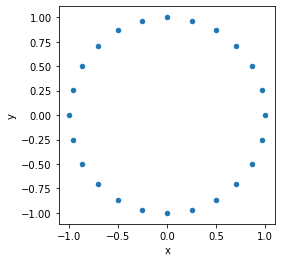

In [0]:
%matplotlib inline
pd.DataFrame({'x': np.sin((2*np.pi) / 24 * np.arange(0,24)), 
              'y': np.cos((2*np.pi) / 24 * np.arange(0,24))}) \
              .plot(x='x', y='y', kind='scatter').set_aspect('equal')

In [0]:
def datetime2circle(dt, period):
    # See https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes
    dt_sin = np.sin(2*np.pi * dt / period)
    dt_cos = np.cos(2*np.pi * dt / period)
    return dt_sin, dt_cos

hour_sin, hour_cos = datetime2circle(df['Dates'].dt.hour, 24)
day_of_week_sin, day_of_week_cos = datetime2circle(df['Dates'].dt.dayofweek, 7)
week_of_year_sin, week_of_year_cos = datetime2circle(df['Dates'].dt.weekofyear, 52)
day_of_month_sin, day_of_month_cos = datetime2circle(df['Dates'].dt.day, df['Dates'].dt.days_in_month)
day_of_year_sin, day_of_year_cos = datetime2circle(df['Dates'].dt.dayofyear, 365)
month_sin, month_cos = datetime2circle(df['Dates'].dt.month, 12)
quarter_sin, quarter_cos = datetime2circle(df['Dates'].dt.quarter, 4)

year = pd.get_dummies(df['Dates'].dt.year, drop_first=True)

police_district = pd.get_dummies(df['PdDistrict'], drop_first=True)

# New feature to indicate if crime occurred at intersection
df['Intersection'] = 1
df.loc[df['Address'].str.contains('Block'), 'Intersection'] = 0

transformed_df = pd.DataFrame()
transformed_df['hour_sin'] = hour_min_sin
transformed_df['hour_cos'] = hour_min_cos
transformed_df['month_sin'] = month_sin
transformed_df['month_cos'] = month_cos
transformed_df['day_of_week_sin'] = day_of_week_sin
transformed_df['day_of_week_cos'] = day_of_week_cos
transformed_df['week_of_year_sin'] = week_of_year_sin
transformed_df['week_of_year_cos'] = week_of_year_cos
transformed_df['day_of_month_sin'] = day_of_month_sin
transformed_df['day_of_month_cos'] = day_of_month_cos
transformed_df['day_of_year_sin'] = day_of_year_sin
transformed_df['day_of_year_cos'] = day_of_year_cos
transformed_df['quarter_sin'] = quarter_sin
transformed_df['quarter_cos'] = quarter_cos
transformed_df['lat'] = df['Y']
transformed_df['long'] = df['X']
transformed_df['intersection'] = df['Intersection']

transformed_df= pd.concat([transformed_df, year, police_district], axis=1)

In [0]:
print(transformed_df.columns)
transformed_df.values.shape
transformed_df.values.dtype

Index([    'hour_min_sin',     'hour_min_cos',        'month_sin',
              'month_cos',  'day_of_week_sin',  'day_of_week_cos',
       'week_of_year_sin', 'week_of_year_cos', 'day_of_month_sin',
       'day_of_month_cos',  'day_of_year_sin',  'day_of_year_cos',
            'quarter_sin',      'quarter_cos',              'lat',
                   'long',     'intersection',               2004,
                     2005,               2006,               2007,
                     2008,               2009,               2010,
                     2011,               2012,               2013,
                     2014,               2015,          'CENTRAL',
              'INGLESIDE',          'MISSION',         'NORTHERN',
                   'PARK',         'RICHMOND',         'SOUTHERN',
                'TARAVAL',       'TENDERLOIN'],
      dtype='object')


dtype('float64')

In [0]:
transformed_df['node'] = range(len(transformed_df))
transformed_df.set_index('node', inplace=True)

### Normalize lat/long

In [0]:
transformed_df['lat'] = (transformed_df['lat'] - transformed_df['lat'].min()) / (transformed_df['lat'].max() - transformed_df['lat'].min()) * 2 - 1
transformed_df['long'] = (transformed_df['long'] - transformed_df['long'].min()) / (transformed_df['long'].max() - transformed_df['long'].min()) * 2 - 1

## Cluster lat/long locations with K-Means

In [0]:
N_CLUSTERS = 2000

In [0]:
%%time
from sklearn.cluster import KMeans, MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=0, verbose=True)
clusters = kmeans.fit_predict(df[['Y','X']])

Init 1/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/3: 0.000005
Init 2/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/3: 0.000004
Init 3/3 with method: k-means++


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:1576: RuntimeWarning: init_size=300 should be larger than k=2000. Setting it to 3*k
  init_size=init_size)


Inertia for init 3/3: 0.000004
Minibatch iteration 1/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 2/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 3/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 4/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 5/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 6/1762300: mean batch inertia: 0.000000, ewa inertia: 0.000001 
Minibatch iteration 7/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 8/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 9/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/1762300: mean batch inertia: 0.000001, ewa inertia: 0.000001 
Minibatch iteration 11/1762300: mean batch inertia: 0.000001, ewa inertia: 0.0

### Assign clusters to nodes

In [0]:
df['cluster'] = clusters

### Visualize cluster centers

In [0]:
pd.DataFrame(kmeans.counts_).describe(percentiles=np.arange(0,1,0.1))

,0
count,2000.000000
mean,1.800000
std,3.490715
min,0.000000
0%,0.000000
10%,0.000000
20%,0.000000
30%,1.000000
40%,1.000000
50%,1.000000


/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


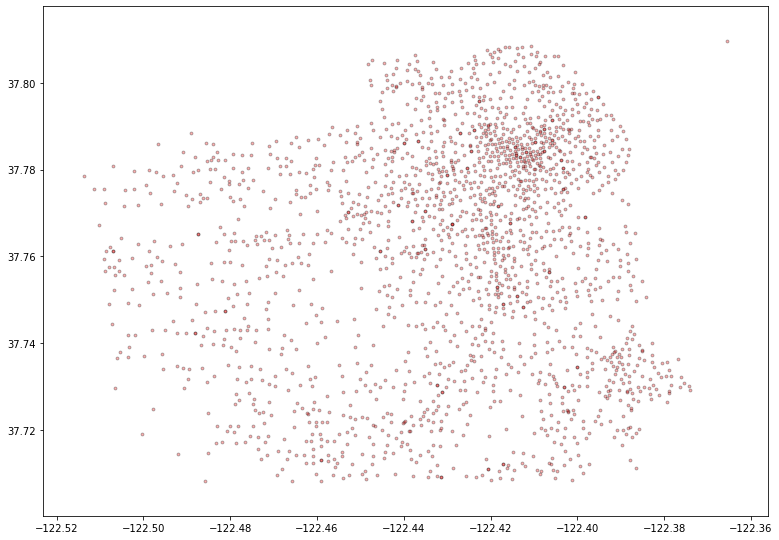

In [0]:
# See http://mattmurray.net/unlocking-the-power-of-geospatial-data-with-geopandas/
geometry = [Point(yx[::-1]) for yx in kmeans.cluster_centers_]
gdf = GeoDataFrame(pd.DataFrame(kmeans.cluster_centers_), geometry=geometry)   
gdf.crs = {'init': 'epsg:4326'}
gdf.plot(figsize=(13,10), marker="o", color="red", markersize=8, edgecolor="black", alpha=0.3)

In [0]:
sf = gpd.read_file('san-francisco.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.rename(columns={'geometry': 'geometry', 'nhood': 'neighborhood_name'}).set_geometry('geometry')
sf.sample(5)

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


,name,cartodb_id,created_at,updated_at,geometry
1,Marina,20,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.44681 37.80540, -122.4467..."
21,Diamond Heights,8,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.43553 37.74146, -122.4356..."
16,Potrero Hill,32,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.37996 37.75206, -122.3827..."
9,Chinatown,36,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.40877 37.79016, -122.4088..."
14,West of Twin Peaks,18,2013-02-10T05:44:04,2013-02-10T05:44:04,"MULTIPOLYGON (((-122.45252 37.72317, -122.4569..."


Text(0.5, 1, 'San Francisco crime clusters')

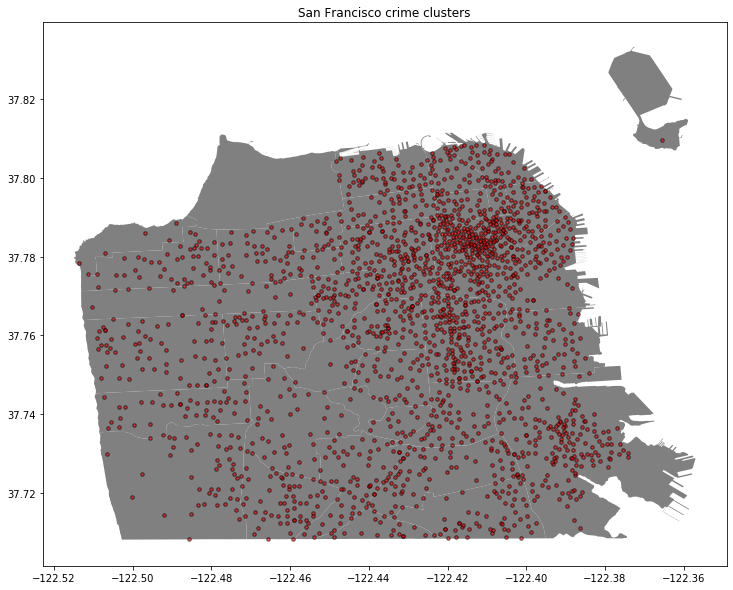

In [0]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
gdf.plot(ax=sf_map, marker="o", color="red", markersize=12, edgecolor="black", alpha=0.6)
ax.set_title("San Francisco crime clusters")

## Build feature that counts # of co-occurring spatial neighbor crimes in same cluster

In [0]:
from collections import defaultdict

n_neighbors_spatial = {}

groups = df.groupby('Dates')
print(f"# groups: {len(groups)}")

for timeidx, group in tqdm(groups):   
    if len(group.node) > 1:
        # Group nodes/crimes by cluster
        group_clusters_set = set(group.cluster)
        cluster2nodes = defaultdict(list)
        for c,n in zip(group.cluster, group.node):
            cluster2nodes[c].append(n)
            
        # Count # of crimes co-occurring in the same cluster
        for n,c in zip(group.node, group.cluster):
            n_neighbors_spatial[n] = len(cluster2nodes[c]) - 1
    else:
        n = list(group.node)[0]
        n_neighbors_spatial[n] = 0

# groups: 781402


In [0]:
transformed_df['spatials_count'] = list(map(n_neighbors_spatial.get, transformed_df.index.values))

In [0]:
transformed_df['spatials_count'].describe(percentiles=np.arange(0,1,0.05))

count    1.762244e+06
mean     5.852833e-01
std      9.742249e-01
min      0.000000e+00
0%       0.000000e+00
5%       0.000000e+00
10%      0.000000e+00
15%      0.000000e+00
20%      0.000000e+00
25%      0.000000e+00
30%      0.000000e+00
35%      0.000000e+00
40%      0.000000e+00
45%      0.000000e+00
50%      0.000000e+00
55%      0.000000e+00
60%      0.000000e+00
65%      1.000000e+00
70%      1.000000e+00
75%      1.000000e+00
80%      1.000000e+00
85%      1.000000e+00
90%      2.000000e+00
95%      2.000000e+00
max      3.900000e+01
Name: spatials_count, dtype: float64

In [0]:
# Standardize spatials count
transformed_df['spatials_count'] = (transformed_df['spatials_count'] - transformed_df['spatials_count'].mean()) / (transformed_df['spatials_count'].std())

## Build address features

### Build a vocab of address words and filter stop words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', tokenizer=str.split)
vectorizer.fit(df.Address.values)
# print(vectorizer.vocabulary_)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<method 'split' of 'str' objects>, vocabulary=None)

In [0]:
addresses_transformed = vectorizer.transform(df.Address.values)

### Record list of address vocab IDs for each sample

In [0]:
address_idx = defaultdict(list)
for row, col in zip(*addresses_transformed.nonzero()):
    address_idx[row].append(col)
    
ADDRESS_VOCAB_SIZE = int(max(vectorizer.vocabulary_.values()) + 2)  # Account for padding
ADDRESS_PAD_IDX = ADDRESS_VOCAB_SIZE - 1                            # Last index is pad 

## Split into Train/Val/Test sets

In [0]:
train_mask = torch.BoolTensor((df.split == 'train').values)
test_mask = torch.BoolTensor((df.split == 'test').values)
print(train_mask.sum())
print(test_mask.sum())

tensor(877982)
tensor(884262)


In [0]:
from sklearn.preprocessing import LabelEncoder

category_le = LabelEncoder()
_ = category_le.fit(df[df.split=='train']['Category'])
y_labels = torch.full([len(df)], -1).long()
y_labels[train_mask] = torch.tensor(category_le.transform(df['Category'].values[train_mask]))

In [0]:
from sklearn.model_selection import train_test_split

train_idxs = (df.split == 'train').values.nonzero()[0]
train_idxs, val_idxs = train_test_split(train_idxs, test_size=0.1, random_state=0, stratify=y_labels[train_mask])
test_idxs = (df.split == 'test').values.nonzero()[0]

In [0]:
n_train = len(train_idxs)
n_val = len(val_idxs)
print(n_train)
print(n_val)

790183
87799


# Build Dataset and Dataloader

In [0]:
from more_itertools import flatten

class CrimeDataset(torch.utils.data.Dataset):
    def __init__(self, idxs, clusters, address_idx, Y):
        self.data_idxs = idxs
        self.clusters = clusters
        self.address_idx = address_idx
        self.Y = Y

    def __len__(self):
        return len(self.data_idxs)

    def __getitem__(self, idx):
        node = self.data_idxs[idx]                          
        cluster = self.clusters[node]                       
        address = torch.LongTensor(self.address_idx[node])  
        y = self.Y[node]                                    
        
        return (torch.LongTensor([node]),     # Node ID
                torch.LongTensor([cluster]),  # Cluster ID        
                address,                      # Sequence of address vocab idxs
                y)                            # Target class for node

In [0]:
from collections import namedtuple

Batch = namedtuple('Batch', 'nodes, clusters, addresses, y')

def collate_batch(data_list):
    '''Build batch with node/cluster idxs and padded address idxs'''
    nodes, clusters, addresses, ys = list(zip(*data_list))
    batch_nodes = torch.cat(nodes)
    batch_clusters = torch.cat(clusters)
    batch_addresses_padded = torch.nn.utils.rnn.pad_sequence(
        addresses, batch_first=True, padding_value=ADDRESS_PAD_IDX
    )

    return Batch(batch_nodes,
                 batch_clusters,
                 batch_addresses_padded,
                 torch.LongTensor(ys))

In [0]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_ds = CrimeDataset(train_idxs, clusters, address_idx, y_labels.numpy())
val_ds = CrimeDataset(val_idxs, clusters, address_idx, y_labels.numpy())
test_ds = CrimeDataset(test_idxs, clusters, address_idx, y_labels.numpy())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=6,
                            collate_fn=lambda data_list: collate_batch(data_list))
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE * 16,
                            shuffle=False, num_workers=6,
                            collate_fn=lambda data_list: collate_batch(data_list))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE * 16,
                            shuffle=False, num_workers=6,
                            collate_fn=lambda data_list: collate_batch(data_list))

# Setup model and train

In [0]:
class CrimeNet(torch.nn.Module):
    def __init__(self, 
                 X, 
                 hidden_dim,
                 n_classes, 
                 n_clusters=kmeans.n_clusters,
                 cluster_embed_dim=8, 
                 address_vocab_size=ADDRESS_VOCAB_SIZE, 
                 address_pad_idx=ADDRESS_PAD_IDX, 
                 dropout=0.1):
        super(CrimeNet, self).__init__()
        self.address_pad_idx = address_pad_idx
        
        # Create non-trainable embedding table for node features
        X = torch.FloatTensor(X)
        self.node_embed = nn.Embedding.from_pretrained(X, freeze=True)
        
        # Trainable embeddings for cluster IDs
        self.cluster_embed = nn.Embedding(n_clusters, cluster_embed_dim)        
        # Traininable embeddings for address vocab words
        self.address_embed = nn.Embedding(address_vocab_size, hidden_dim, padding_idx=self.address_pad_idx)
        
        # Linear projection layer for nodes to have same hidden dimensionality
        self.node_fc = nn.Linear(X.shape[1], hidden_dim, bias=True)

        # LSTM layer for address sequences
        self.address_rnn = nn.LSTM(
            hidden_dim, hidden_dim, num_layers=1, batch_first=True, dropout=dropout, bidirectional=False
        )
        
        # Fully-connected layer for node + cluster + address vecs
        self.fc = torch.nn.Linear(hidden_dim * 2 + cluster_embed_dim, hidden_dim)
        self.ln = torch.nn.LayerNorm(hidden_dim)
        # Output layer with one prediction per class
        self.out = torch.nn.Linear(hidden_dim, n_classes)
        
        # Regularization shared for all layers
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, nodes, clusters, addresses, return_probs=False):
        # Look up node features 
        nodes = self.node_embed(nodes)
        # Pass through FC layer
        nodes = F.relu(self.node_fc(nodes))
        
        # Embed the cluster IDs
        clusters = self.cluster_embed(clusters)
        
        # Calculate length of address rows for packing
        lens = (addresses != self.address_pad_idx).sum(1)
        # Embed addresses with vocab IDs
        addresses = self.dropout(self.address_embed(addresses))
        # Pack address sequences to remove padding and improve performance
        addresses_packed = torch.nn.utils.rnn.pack_padded_sequence(
            addresses, lens, batch_first=True, enforce_sorted=False
        )
        # Run the LSTM over address sequences
        output, (hidden, cell) = self.address_rnn(addresses_packed)
        # Use last layer hidden state as the representation for each address
        addresses = hidden[-1]  
        
        # Concatenate node features, address LSTM outs, and cluster embeds
        x = self.dropout(torch.cat([nodes, addresses, clusters], dim=-1))
        # Fully-connected layer with ReLU
        x = self.dropout(self.ln(F.relu(self.fc(x))))
        # Output shape is [batch_size, n_classes]
        x = self.out(x)
        
        if return_probs:
            # Normalize to a probability distribution before returning
            return F.softmax(x, dim=1)
        else:
            # Return logits only
            return x

In [0]:
np.random.seed(0)
torch.manual_seed(0)
model = CrimeNet(transformed_df.values, hidden_dim=256, cluster_embed_dim=8, n_classes=len(category_le.classes_), dropout=0.3)
model

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


CrimeNet(
  (node_embed): Embedding(1762244, 39)
  (cluster_embed): Embedding(2000, 8)
  (address_embed): Embedding(2189, 256, padding_idx=2188)
  (node_fc): Linear(in_features=39, out_features=256, bias=True)
  (address_rnn): LSTM(256, 256, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=520, out_features=256, bias=True)
  (ln): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (out): Linear(in_features=256, out_features=39, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Move model to device
model = model.to(device)

In [0]:
# Use Adam optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Reduce LR by 20% after 3 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.8)

In [0]:
best_val_loss = float('inf')
early_stop = 0

for e in range(1, 101):  # 100 epochs max
    t_s = time.perf_counter()
    
    ### TRAINING LOOP ###
    model.train()
    
    train_acc, train_loss = 0, 0   # Running tally of accuracy & loss
    train_preds, train_y = [], []  # Track preds/labels for calculating metrics
    for batch in tqdm(train_loader, total=n_train // BATCH_SIZE):
        optimizer.zero_grad()
        logits = model(  # Forward pass
            batch.nodes.to(device), batch.clusters.to(device), batch.addresses.to(device)
        )
        # Calculate cross entropy loss and perform backward pass
        loss = F.cross_entropy(logits, batch.y.to(device))
        loss.backward()
        optimizer.step()
        
        # Update metrics
        preds = logits.argmax(1)  # Prediction is index of highest logit score
        train_preds.extend(preds.cpu().numpy())
        train_y.extend(batch.y.cpu().numpy())
        train_acc += preds.eq(batch.y.to(device)).sum().item()
        train_loss += loss.item() * batch.y.shape[0]
    # Calculate metrics across whole set
    train_acc  /= n_train    
    train_loss /= n_train
    train_f1_macro = f1_score(train_y, train_preds, average='macro')
    
    ### VALIDATION LOOP ###
    model.eval()
    
    with torch.no_grad():
        val_acc, val_loss = 0, 0
        val_preds, val_y = [], []
        for batch in val_loader:
            logits = model(
                batch.nodes.to(device), batch.clusters.to(device), batch.addresses.to(device)
            )
            loss = F.cross_entropy(logits, batch.y.to(device))
            val_loss += loss.item() * batch.y.shape[0]
            preds = logits.argmax(1)  # Prediction is index of highest logit score
            val_preds.extend(preds.cpu().numpy())
            val_y.extend(batch.y.cpu().numpy())
            val_acc += preds.eq(batch.y.to(device)).sum().item()
        # Calculate validation metrics
        val_acc  /= n_val
        val_loss /= n_val
        val_f1_macro = f1_score(val_y, val_preds, average='macro')
        
        if val_loss < best_val_loss:
            # Save checkpoint if validation loss improves
            best_val_loss = val_loss
            model_path = f"crimenet_epoch_{e}_valloss_{val_loss:.4f}.pt"
            print("\tSaving to", model_path)
            torch.save(model.state_dict(), model_path)
            early_stop = 0
        else:
            # Stop early if validation loss does not improve for 6 epochs
            early_stop += 1
            if early_stop >= 6:
                print(f"No improvement after {early_stop} epochs, stopping early")
                break
    
    scheduler.step(val_loss)
        
    t_e = time.perf_counter()
    print(f"Epoch {e} - "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  Train F1 Macro: {train_f1_macro:.4f}  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}  Val F1 Macro: {val_f1_macro:.4f}  "
          f"Time: {t_e - t_s:.1f}")


	Saving to crimenet_epoch_1_valloss_2.2455.pt
Epoch 1 - Train Loss: 2.3293  Train Acc: 0.2951  Train F1 Macro: 0.0774  Val Loss: 2.2455  Val Acc: 0.3163  Val F1 Macro: 0.0912  Time: 61.2



	Saving to crimenet_epoch_2_valloss_2.2200.pt
Epoch 2 - Train Loss: 2.2619  Train Acc: 0.3115  Train F1 Macro: 0.0909  Val Loss: 2.2200  Val Acc: 0.3216  Val F1 Macro: 0.0970  Time: 61.8



	Saving to crimenet_epoch_3_valloss_2.2039.pt
Epoch 3 - Train Loss: 2.2398  Train Acc: 0.3167  Train F1 Macro: 0.0959  Val Loss: 2.2039  Val Acc: 0.3262  Val F1 Macro: 0.1035  Time: 62.6



	Saving to crimenet_epoch_4_valloss_2.1960.pt
Epoch 4 - Train Loss: 2.2264  Train Acc: 0.3192  Train F1 Macro: 0.0983  Val Loss: 2.1960  Val Acc: 0.3288  Val F1 Macro: 0.1030  Time: 62.4



	Saving to crimenet_epoch_5_valloss_2.1890.pt
Epoch 5 - Train Loss: 2.2164  Train Acc: 0.3213  Train F1 Macro: 0.1003  Val Loss: 2.1890  Val Acc: 0.3284  Val F1 Macro: 0.1016  Time: 62.2



	Saving to crimenet_epoch_6_valloss_2.1835.pt
Epoch 6 - Train Loss: 2.2082  Train Acc: 0.3236  Train F1 Macro: 0.1018  Val Loss: 2.1835  Val Acc: 0.3312  Val F1 Macro: 0.1060  Time: 62.5



	Saving to crimenet_epoch_7_valloss_2.1793.pt
Epoch 7 - Train Loss: 2.2013  Train Acc: 0.3251  Train F1 Macro: 0.1038  Val Loss: 2.1793  Val Acc: 0.3301  Val F1 Macro: 0.1063  Time: 64.8



	Saving to crimenet_epoch_8_valloss_2.1763.pt
Epoch 8 - Train Loss: 2.1963  Train Acc: 0.3264  Train F1 Macro: 0.1047  Val Loss: 2.1763  Val Acc: 0.3317  Val F1 Macro: 0.1069  Time: 60.7



	Saving to crimenet_epoch_9_valloss_2.1753.pt
Epoch 9 - Train Loss: 2.1908  Train Acc: 0.3270  Train F1 Macro: 0.1058  Val Loss: 2.1753  Val Acc: 0.3312  Val F1 Macro: 0.1046  Time: 60.9



	Saving to crimenet_epoch_10_valloss_2.1723.pt
Epoch 10 - Train Loss: 2.1877  Train Acc: 0.3286  Train F1 Macro: 0.1070  Val Loss: 2.1723  Val Acc: 0.3335  Val F1 Macro: 0.1095  Time: 60.8



	Saving to crimenet_epoch_11_valloss_2.1698.pt
Epoch 11 - Train Loss: 2.1838  Train Acc: 0.3286  Train F1 Macro: 0.1077  Val Loss: 2.1698  Val Acc: 0.3343  Val F1 Macro: 0.1101  Time: 60.7



	Saving to crimenet_epoch_12_valloss_2.1684.pt
Epoch 12 - Train Loss: 2.1803  Train Acc: 0.3300  Train F1 Macro: 0.1092  Val Loss: 2.1684  Val Acc: 0.3335  Val F1 Macro: 0.1069  Time: 61.0



	Saving to crimenet_epoch_13_valloss_2.1665.pt
Epoch 13 - Train Loss: 2.1778  Train Acc: 0.3301  Train F1 Macro: 0.1087  Val Loss: 2.1665  Val Acc: 0.3331  Val F1 Macro: 0.1059  Time: 60.8



	Saving to crimenet_epoch_14_valloss_2.1646.pt
Epoch 14 - Train Loss: 2.1739  Train Acc: 0.3313  Train F1 Macro: 0.1097  Val Loss: 2.1646  Val Acc: 0.3338  Val F1 Macro: 0.1092  Time: 62.0



	Saving to crimenet_epoch_15_valloss_2.1629.pt
Epoch 15 - Train Loss: 2.1722  Train Acc: 0.3316  Train F1 Macro: 0.1094  Val Loss: 2.1629  Val Acc: 0.3356  Val F1 Macro: 0.1123  Time: 61.8



Epoch 16 - Train Loss: 2.1700  Train Acc: 0.3323  Train F1 Macro: 0.1111  Val Loss: 2.1639  Val Acc: 0.3349  Val F1 Macro: 0.1126  Time: 60.3



Epoch 17 - Train Loss: 2.1673  Train Acc: 0.3327  Train F1 Macro: 0.1110  Val Loss: 2.1636  Val Acc: 0.3354  Val F1 Macro: 0.1106  Time: 60.8



	Saving to crimenet_epoch_18_valloss_2.1620.pt
Epoch 18 - Train Loss: 2.1659  Train Acc: 0.3330  Train F1 Macro: 0.1115  Val Loss: 2.1620  Val Acc: 0.3349  Val F1 Macro: 0.1114  Time: 61.0



	Saving to crimenet_epoch_19_valloss_2.1602.pt
Epoch 19 - Train Loss: 2.1636  Train Acc: 0.3336  Train F1 Macro: 0.1122  Val Loss: 2.1602  Val Acc: 0.3364  Val F1 Macro: 0.1140  Time: 61.3



Epoch 20 - Train Loss: 2.1612  Train Acc: 0.3342  Train F1 Macro: 0.1129  Val Loss: 2.1618  Val Acc: 0.3348  Val F1 Macro: 0.1147  Time: 60.3



Epoch 21 - Train Loss: 2.1602  Train Acc: 0.3352  Train F1 Macro: 0.1137  Val Loss: 2.1605  Val Acc: 0.3358  Val F1 Macro: 0.1102  Time: 60.4



	Saving to crimenet_epoch_22_valloss_2.1598.pt
Epoch 22 - Train Loss: 2.1590  Train Acc: 0.3350  Train F1 Macro: 0.1139  Val Loss: 2.1598  Val Acc: 0.3369  Val F1 Macro: 0.1151  Time: 60.5



	Saving to crimenet_epoch_23_valloss_2.1585.pt
Epoch 23 - Train Loss: 2.1572  Train Acc: 0.3351  Train F1 Macro: 0.1142  Val Loss: 2.1585  Val Acc: 0.3368  Val F1 Macro: 0.1133  Time: 60.9



Epoch 24 - Train Loss: 2.1559  Train Acc: 0.3354  Train F1 Macro: 0.1141  Val Loss: 2.1595  Val Acc: 0.3360  Val F1 Macro: 0.1176  Time: 60.2



	Saving to crimenet_epoch_25_valloss_2.1576.pt
Epoch 25 - Train Loss: 2.1542  Train Acc: 0.3360  Train F1 Macro: 0.1141  Val Loss: 2.1576  Val Acc: 0.3368  Val F1 Macro: 0.1177  Time: 61.0



Epoch 26 - Train Loss: 2.1532  Train Acc: 0.3366  Train F1 Macro: 0.1153  Val Loss: 2.1594  Val Acc: 0.3353  Val F1 Macro: 0.1140  Time: 60.7



	Saving to crimenet_epoch_27_valloss_2.1566.pt
Epoch 27 - Train Loss: 2.1524  Train Acc: 0.3362  Train F1 Macro: 0.1154  Val Loss: 2.1566  Val Acc: 0.3370  Val F1 Macro: 0.1147  Time: 60.1



	Saving to crimenet_epoch_28_valloss_2.1556.pt
Epoch 28 - Train Loss: 2.1504  Train Acc: 0.3369  Train F1 Macro: 0.1158  Val Loss: 2.1556  Val Acc: 0.3369  Val F1 Macro: 0.1132  Time: 61.2



Epoch 29 - Train Loss: 2.1496  Train Acc: 0.3372  Train F1 Macro: 0.1164  Val Loss: 2.1576  Val Acc: 0.3364  Val F1 Macro: 0.1145  Time: 62.7



Epoch 30 - Train Loss: 2.1487  Train Acc: 0.3370  Train F1 Macro: 0.1159  Val Loss: 2.1556  Val Acc: 0.3376  Val F1 Macro: 0.1142  Time: 61.5



Epoch 31 - Train Loss: 2.1476  Train Acc: 0.3373  Train F1 Macro: 0.1159  Val Loss: 2.1576  Val Acc: 0.3366  Val F1 Macro: 0.1144  Time: 61.5



	Saving to crimenet_epoch_32_valloss_2.1554.pt
Epoch 32 - Train Loss: 2.1472  Train Acc: 0.3379  Train F1 Macro: 0.1168  Val Loss: 2.1554  Val Acc: 0.3379  Val F1 Macro: 0.1147  Time: 62.1



	Saving to crimenet_epoch_33_valloss_2.1540.pt
Epoch 33 - Train Loss: 2.1420  Train Acc: 0.3391  Train F1 Macro: 0.1167  Val Loss: 2.1540  Val Acc: 0.3360  Val F1 Macro: 0.1159  Time: 62.9



	Saving to crimenet_epoch_34_valloss_2.1539.pt
Epoch 34 - Train Loss: 2.1409  Train Acc: 0.3389  Train F1 Macro: 0.1179  Val Loss: 2.1539  Val Acc: 0.3356  Val F1 Macro: 0.1163  Time: 62.6



	Saving to crimenet_epoch_35_valloss_2.1525.pt
Epoch 35 - Train Loss: 2.1396  Train Acc: 0.3395  Train F1 Macro: 0.1182  Val Loss: 2.1525  Val Acc: 0.3370  Val F1 Macro: 0.1162  Time: 63.3



	Saving to crimenet_epoch_36_valloss_2.1518.pt
Epoch 36 - Train Loss: 2.1382  Train Acc: 0.3395  Train F1 Macro: 0.1189  Val Loss: 2.1518  Val Acc: 0.3380  Val F1 Macro: 0.1166  Time: 61.5



Epoch 37 - Train Loss: 2.1369  Train Acc: 0.3398  Train F1 Macro: 0.1192  Val Loss: 2.1527  Val Acc: 0.3368  Val F1 Macro: 0.1176  Time: 60.0



Epoch 38 - Train Loss: 2.1364  Train Acc: 0.3399  Train F1 Macro: 0.1192  Val Loss: 2.1520  Val Acc: 0.3375  Val F1 Macro: 0.1151  Time: 59.7



Epoch 39 - Train Loss: 2.1358  Train Acc: 0.3399  Train F1 Macro: 0.1193  Val Loss: 2.1523  Val Acc: 0.3391  Val F1 Macro: 0.1186  Time: 60.6



	Saving to crimenet_epoch_40_valloss_2.1517.pt
Epoch 40 - Train Loss: 2.1346  Train Acc: 0.3408  Train F1 Macro: 0.1193  Val Loss: 2.1517  Val Acc: 0.3377  Val F1 Macro: 0.1169  Time: 60.9



	Saving to crimenet_epoch_41_valloss_2.1509.pt
Epoch 41 - Train Loss: 2.1325  Train Acc: 0.3412  Train F1 Macro: 0.1189  Val Loss: 2.1509  Val Acc: 0.3394  Val F1 Macro: 0.1209  Time: 61.7



Epoch 42 - Train Loss: 2.1304  Train Acc: 0.3409  Train F1 Macro: 0.1201  Val Loss: 2.1514  Val Acc: 0.3386  Val F1 Macro: 0.1169  Time: 60.5



	Saving to crimenet_epoch_43_valloss_2.1506.pt
Epoch 43 - Train Loss: 2.1293  Train Acc: 0.3417  Train F1 Macro: 0.1205  Val Loss: 2.1506  Val Acc: 0.3388  Val F1 Macro: 0.1191  Time: 60.9



Epoch 44 - Train Loss: 2.1286  Train Acc: 0.3419  Train F1 Macro: 0.1212  Val Loss: 2.1522  Val Acc: 0.3378  Val F1 Macro: 0.1180  Time: 60.1



Epoch 45 - Train Loss: 2.1276  Train Acc: 0.3421  Train F1 Macro: 0.1212  Val Loss: 2.1513  Val Acc: 0.3374  Val F1 Macro: 0.1189  Time: 59.8



	Saving to crimenet_epoch_46_valloss_2.1503.pt
Epoch 46 - Train Loss: 2.1267  Train Acc: 0.3423  Train F1 Macro: 0.1212  Val Loss: 2.1503  Val Acc: 0.3379  Val F1 Macro: 0.1175  Time: 60.9



Epoch 47 - Train Loss: 2.1254  Train Acc: 0.3431  Train F1 Macro: 0.1219  Val Loss: 2.1508  Val Acc: 0.3389  Val F1 Macro: 0.1180  Time: 59.7



	Saving to crimenet_epoch_48_valloss_2.1494.pt
Epoch 48 - Train Loss: 2.1254  Train Acc: 0.3428  Train F1 Macro: 0.1220  Val Loss: 2.1494  Val Acc: 0.3387  Val F1 Macro: 0.1179  Time: 61.0



Epoch 49 - Train Loss: 2.1247  Train Acc: 0.3423  Train F1 Macro: 0.1205  Val Loss: 2.1495  Val Acc: 0.3384  Val F1 Macro: 0.1202  Time: 61.0



	Saving to crimenet_epoch_50_valloss_2.1483.pt
Epoch 50 - Train Loss: 2.1240  Train Acc: 0.3430  Train F1 Macro: 0.1219  Val Loss: 2.1483  Val Acc: 0.3396  Val F1 Macro: 0.1215  Time: 60.8



Epoch 51 - Train Loss: 2.1236  Train Acc: 0.3430  Train F1 Macro: 0.1220  Val Loss: 2.1491  Val Acc: 0.3386  Val F1 Macro: 0.1217  Time: 60.2



Epoch 52 - Train Loss: 2.1233  Train Acc: 0.3433  Train F1 Macro: 0.1216  Val Loss: 2.1486  Val Acc: 0.3404  Val F1 Macro: 0.1206  Time: 59.6



Epoch 53 - Train Loss: 2.1223  Train Acc: 0.3430  Train F1 Macro: 0.1213  Val Loss: 2.1487  Val Acc: 0.3399  Val F1 Macro: 0.1208  Time: 59.7



	Saving to crimenet_epoch_54_valloss_2.1473.pt
Epoch 54 - Train Loss: 2.1214  Train Acc: 0.3438  Train F1 Macro: 0.1235  Val Loss: 2.1473  Val Acc: 0.3405  Val F1 Macro: 0.1209  Time: 60.3



Epoch 55 - Train Loss: 2.1211  Train Acc: 0.3436  Train F1 Macro: 0.1238  Val Loss: 2.1498  Val Acc: 0.3380  Val F1 Macro: 0.1203  Time: 61.2



Epoch 56 - Train Loss: 2.1205  Train Acc: 0.3439  Train F1 Macro: 0.1225  Val Loss: 2.1490  Val Acc: 0.3393  Val F1 Macro: 0.1199  Time: 60.3



Epoch 57 - Train Loss: 2.1199  Train Acc: 0.3439  Train F1 Macro: 0.1227  Val Loss: 2.1492  Val Acc: 0.3392  Val F1 Macro: 0.1229  Time: 60.3



Epoch 58 - Train Loss: 2.1193  Train Acc: 0.3441  Train F1 Macro: 0.1231  Val Loss: 2.1491  Val Acc: 0.3402  Val F1 Macro: 0.1189  Time: 60.4



Epoch 59 - Train Loss: 2.1172  Train Acc: 0.3440  Train F1 Macro: 0.1240  Val Loss: 2.1477  Val Acc: 0.3394  Val F1 Macro: 0.1213  Time: 59.6



	Saving to crimenet_epoch_60_valloss_2.1473.pt
Epoch 60 - Train Loss: 2.1164  Train Acc: 0.3442  Train F1 Macro: 0.1230  Val Loss: 2.1473  Val Acc: 0.3391  Val F1 Macro: 0.1226  Time: 61.5



	Saving to crimenet_epoch_61_valloss_2.1471.pt
Epoch 61 - Train Loss: 2.1156  Train Acc: 0.3447  Train F1 Macro: 0.1238  Val Loss: 2.1471  Val Acc: 0.3396  Val F1 Macro: 0.1230  Time: 61.0



	Saving to crimenet_epoch_62_valloss_2.1465.pt
Epoch 62 - Train Loss: 2.1148  Train Acc: 0.3454  Train F1 Macro: 0.1258  Val Loss: 2.1465  Val Acc: 0.3398  Val F1 Macro: 0.1210  Time: 60.9



	Saving to crimenet_epoch_63_valloss_2.1464.pt
Epoch 63 - Train Loss: 2.1142  Train Acc: 0.3450  Train F1 Macro: 0.1250  Val Loss: 2.1464  Val Acc: 0.3398  Val F1 Macro: 0.1198  Time: 61.5



Epoch 64 - Train Loss: 2.1133  Train Acc: 0.3453  Train F1 Macro: 0.1245  Val Loss: 2.1476  Val Acc: 0.3398  Val F1 Macro: 0.1222  Time: 61.2



Epoch 65 - Train Loss: 2.1131  Train Acc: 0.3451  Train F1 Macro: 0.1245  Val Loss: 2.1472  Val Acc: 0.3399  Val F1 Macro: 0.1241  Time: 61.8


Buffered data was truncated after reaching the output size limit.

# Continue training on Val data

In [0]:
print(model_path)
model.load_state_dict(torch.load(model_path))

crimenet_epoch_79_valloss_2.1448.pt


<All keys matched successfully>

In [0]:
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE,
                            shuffle=True, num_workers=6,
                            collate_fn=lambda data_list: collate_batch(data_list))

In [0]:
val_epochs = 10

for e in range(0, val_epochs):
    print(e)
    model.train()
    
    for batch in val_loader:
        optimizer.zero_grad()
        logits = model(  # Forward pass
            batch.nodes.to(device), batch.clusters.to(device), batch.addresses.to(device)
        )
        # Calculate cross entropy loss and perform backward pass
        loss = F.cross_entropy(logits, batch.y.to(device))
        loss.backward()
        optimizer.step()

0
1
2
3
4
5
6
7
8
9


# Build submission CSV

## Predict class for each test point

In [0]:
def predict_test(model):
    preds = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            probs = model(
                batch.nodes.to(device), batch.clusters.to(device), batch.addresses.to(device), return_probs=True
            ).cpu().numpy()
            preds.extend(list(probs))
    preds = np.stack(preds)
    return preds

In [0]:
preds_afterval = predict_test(model)

In [0]:
df_submission = pd.DataFrame(columns=category_le.classes_, data=preds_afterval)

In [0]:
df_submission['Id'] = df[df.split=='test']['Id'].values.astype('int')

In [0]:
df_submission.sort_values('Id', inplace=True)

In [0]:
df_submission = df_submission[[ 'Id','ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY',
       'DISORDERLY CONDUCT', 'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC',
       'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION', 'FAMILY OFFENSES',
       'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING',
       'LARCENY/THEFT', 'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON',
       'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT',
       'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY',
       'SECONDARY CODES', 'SEX OFFENSES FORCIBLE', 'SEX OFFENSES NON FORCIBLE',
       'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS',
       'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS']]

In [0]:
df_submission.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,EMBEZZLEMENT,EXTORTION,FAMILY OFFENSES,FORGERY/COUNTERFEITING,FRAUD,GAMBLING,KIDNAPPING,LARCENY/THEFT,LIQUOR LAWS,LOITERING,MISSING PERSON,NON-CRIMINAL,OTHER OFFENSES,PORNOGRAPHY/OBSCENE MAT,PROSTITUTION,RECOVERED VEHICLE,ROBBERY,RUNAWAY,SECONDARY CODES,SEX OFFENSES FORCIBLE,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
884261,0,0.006319,0.062993,0.000004,0.000010,0.024811,0.001677,0.000673,0.001534,0.000462,0.000044,0.000040,0.000252,0.000167,0.002213,0.000001,0.000374,0.276411,0.000034,0.000001,0.020413,0.100278,0.092209,7.344786e-08,0.000017,0.000127,0.013720,0.000853,0.000019,0.004666,0.000044,0.000198,0.000692,0.039971,1.147872e-09,0.001471,0.095002,0.232834,0.014177,0.005287
884260,1,0.000687,0.062517,0.000021,0.000014,0.000531,0.000567,0.010114,0.015112,0.001917,0.000057,0.000048,0.000082,0.000869,0.001838,0.000058,0.000960,0.073955,0.000751,0.000209,0.001942,0.057922,0.511656,3.934504e-08,0.000059,0.000469,0.074780,0.000049,0.000032,0.002357,0.000035,0.000636,0.000021,0.044249,5.468121e-10,0.000126,0.031572,0.049454,0.048007,0.006328
884259,2,0.002889,0.029523,0.000008,0.000002,0.145754,0.001056,0.001859,0.000465,0.000203,0.000154,0.000032,0.000055,0.000483,0.004718,0.000002,0.000424,0.466273,0.000042,0.000005,0.003186,0.069729,0.041176,1.440238e-08,0.000024,0.000037,0.008671,0.000042,0.000004,0.001841,0.000003,0.000213,0.000265,0.025353,4.255993e-10,0.003567,0.102258,0.085467,0.003302,0.000915
884258,3,0.001947,0.260522,0.000072,0.001976,0.014404,0.005173,0.003503,0.041304,0.028094,0.000168,0.000815,0.000414,0.002774,0.010556,0.000245,0.008306,0.030874,0.012279,0.000343,0.030258,0.048805,0.126117,1.036602e-06,0.001498,0.000425,0.051599,0.001831,0.064546,0.011370,0.000159,0.005156,0.000420,0.050332,1.001539e-06,0.007868,0.057045,0.008799,0.075753,0.034247
884257,4,0.001947,0.260522,0.000072,0.001976,0.014404,0.005173,0.003503,0.041304,0.028094,0.000168,0.000815,0.000414,0.002774,0.010556,0.000245,0.008306,0.030874,0.012279,0.000343,0.030258,0.048805,0.126117,1.036602e-06,0.001498,0.000425,0.051599,0.001831,0.064546,0.011370,0.000159,0.005156,0.000420,0.050332,1.001539e-06,0.007868,0.057045,0.008799,0.075753,0.034247


In [0]:
%%time
df_submission.to_csv(f"submission_ValEpochs_{val_epochs}_ValLoss_{best_val_loss:.4f}.csv.gz", index=False, compression='gzip')

CPU times: user 2min 19s, sys: 137 ms, total: 2min 19s
Wall time: 2min 20s
